## 2. Available Script:

In [2]:
# execute this for the 1st time\n",
# !pip install -r example-requirements.txt \n",

# download file \n",
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux\n",

# and place in folder data/"

! pip install statsmodels --upgrade

--2023-12-01 14:57:30--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.12
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat’

data3SS2009.mat     100%[===================>] 255.24M  18.3MB/s    in 12s     

2023-12-01 14:57:43 (20.9 MB/s) - ‘data3SS2009.mat’ saved [267634147/267634147]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [5]:
fname = join(os.getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)
y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

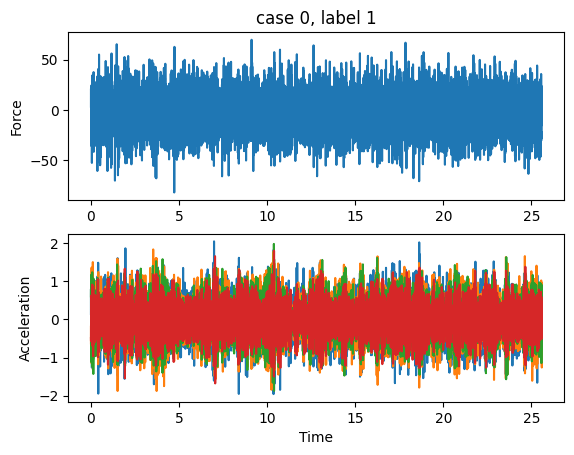

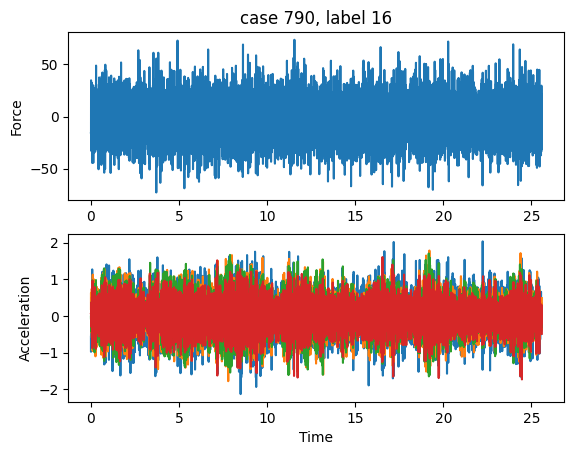

In [6]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()


## AR Models

**a. Ch2-Ch5, concatenating each AR model coefficient of each channel (model order = 30)**

**a. X1 ---> 850lines; 30*4=120 columns**

In [7]:
X = np.concatenate((Ch2,Ch3,Ch4,Ch5))
X
print( 'matrix X: ', X, '\n matrix X.shape: ',X.shape)


matrix X:  [[ 0.14656393  0.12344872 -0.42452564 ...  0.62527312  0.18531354
  -0.08524884]
 [ 0.79236289  0.26123975 -0.52503197 ...  0.5761841   0.75775165
  -0.38039847]
 [ 0.17113439  0.98893784  0.60084113 ... -0.10711284  0.6940215
  -0.20874206]
 ...
 [ 0.21738063  0.40702133  0.44190305 ... -0.43805704  0.31272412
   0.07283314]
 [-0.03923676  0.18921679  0.05709407 ... -0.40076345  0.02953589
   0.34142521]
 [ 0.03684378 -0.30327268 -0.64940672 ... -0.17947949 -0.69738006
   0.42497897]] 
 matrix X.shape:  (32768, 850)


In [8]:
FeatAR = []  # Feature extraction AR
na = 29      # Model Order = 30 (0-29)
for i in range(0,850):
  ARmodel2 = AutoReg(Ch2[:,i],na).fit()
  ARmodel3 = AutoReg(Ch3[:,i],na).fit()
  ARmodel4 = AutoReg(Ch4[:,i],na).fit()
  ARmodel5 = AutoReg(Ch5[:,i],na).fit()
  ARparams = np.concatenate([ARmodel2.params,ARmodel3.params, ARmodel4.params,ARmodel5.params])
  FeatAR.append(ARparams)
FeatAR = np.array(FeatAR)

X1 = FeatAR
print('matrix X1: ',X1.shape)


matrix X1:  (850, 120)


## PCA

**b. PCA of the matrix built in 4.a.a.**

   **a. X2 ---> 850 lines; << 120 columns after dimensionality reduction**

matrix X2:  (850, 6)
Percentage of Explained Variance: [64.7  12.65  9.02  5.11  2.62  1.95]
Cumulative Variance Explained: [64.7  77.35 86.37 91.48 94.1  96.05]


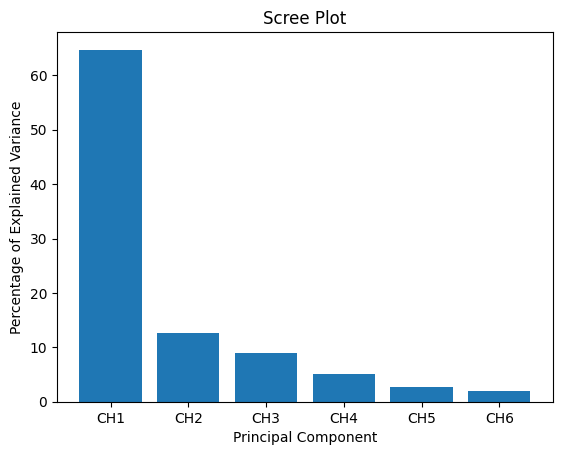

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # 95% Intervalo de confiança
X2 = pca.fit_transform(FeatAR)
per_var = np.round(pca.explained_variance_ratio_*100,decimals=2)
labels = ['CH'+str(X) for X in range(1,len(per_var)+1)]

# Quantos componentes explicam ao menos 95% da variabilidade dos dados?
print('matrix X2: ',X2.shape)
print('Percentage of Explained Variance:', per_var)
print('Cumulative Variance Explained:',np.cumsum(per_var))

# Plot
plt.bar(x=range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
#plt.plot(per_var,'ro-')
plt.show()

## Scaling features to a range

**b.Scale all features individually in e.g. [-1,1]**


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# AR Model
X1_data = scaler.fit_transform(X1)
X1_data.max()
X1_data.min()

# PCA Model
X2_data = scaler.fit_transform(X2)
X2_data.max()
X2_data.min()

# Print the data with the scaled features
print('Matrix X1_Train:',X1_data.shape)
print('Matrix X2_Train:',X2_data.shape)
print('Normalização:','\n X1 máximo normalizado: ', X1_data.max(), '\n X1 mínimo normalizado: ',X1_data.min(),'\n X2 máximo normalizado: ', X2_data.max(), '\n X2 minimo normalizado: ',X2_data.min())


Matrix X1_Train: (850, 120)
Matrix X2_Train: (850, 6)
Normalização: 
 X1 máximo normalizado:  1.0000000000000004 
 X1 mínimo normalizado:  -1.0 
 X2 máximo normalizado:  1.0000000000000004 
 X2 minimo normalizado:  -1.0


## Plots

**c. Visualize and compare X1, X2 (see code in Plotting multidimensional spaces)**

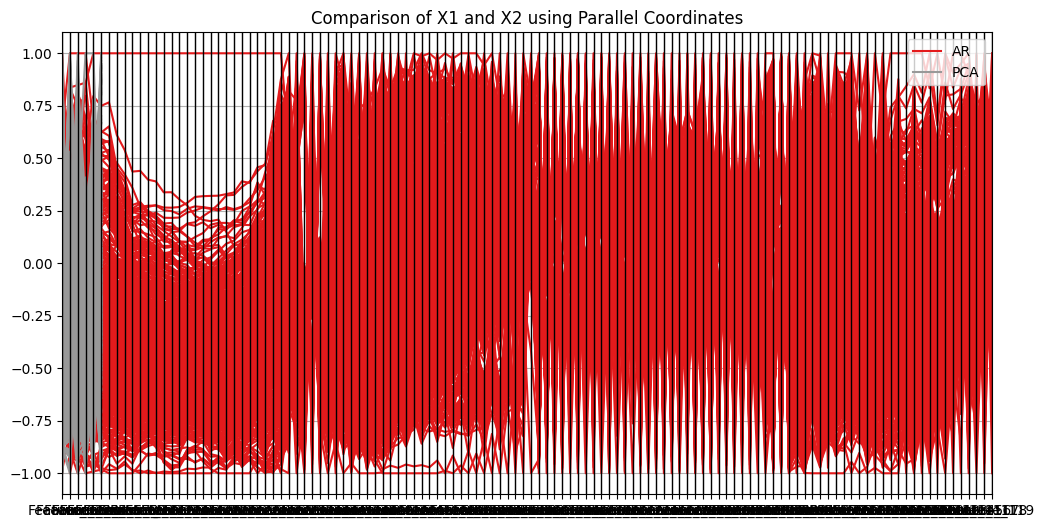

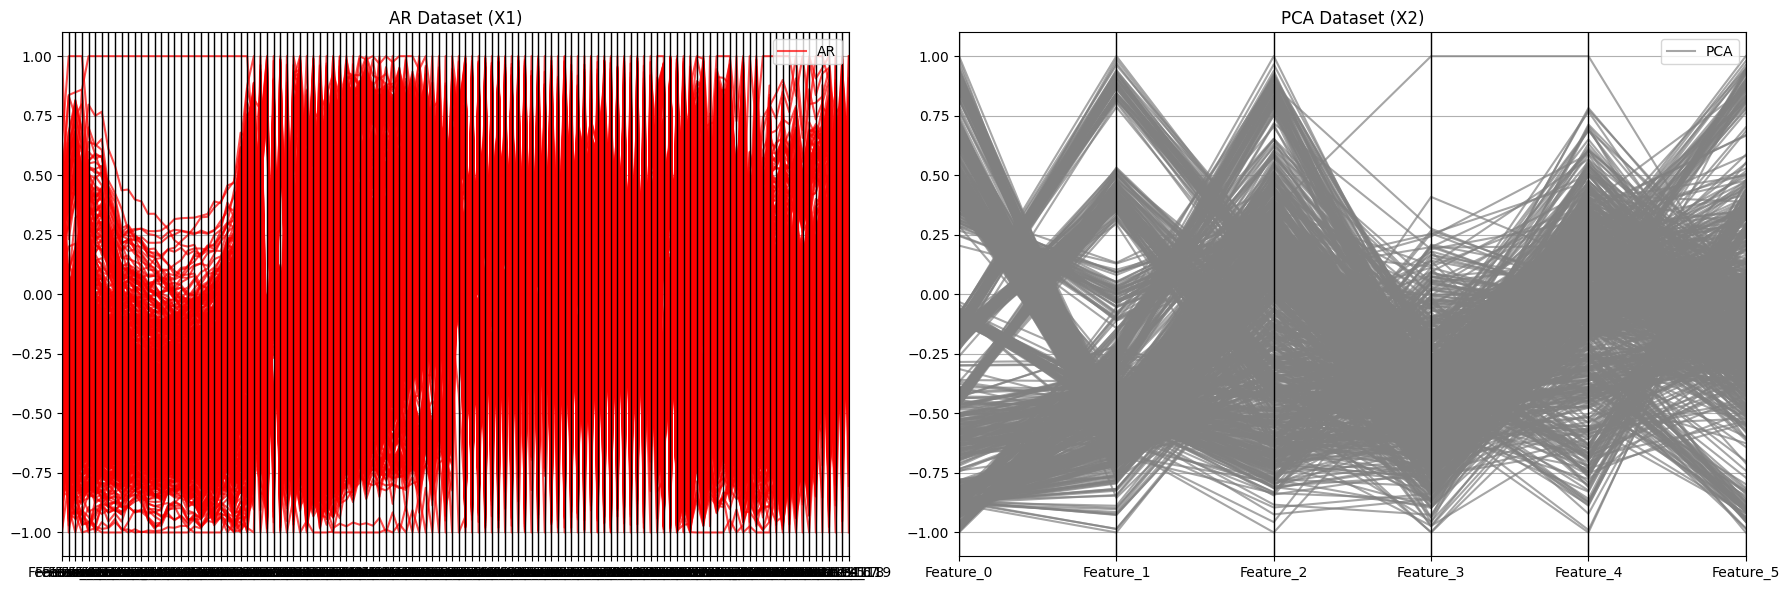

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

# Combine the datasets
data1 = pd.DataFrame(X1_data, columns=[f'Feature_{i}' for i in range(120)])
data2 = pd.DataFrame(X2_data, columns=[f'Feature_{i}' for i in range(6)])

# Add a label to distinguish between X1 and X2
data1['Dataset'] = 'AR'
data2['Dataset'] = 'PCA'

# Combine the data for plotting
combined_data = pd.concat([data1, data2])

# Parallel coordinate plot
plt.figure(figsize=(12, 6))
parallel_coordinates(combined_data, 'Dataset', colormap='Set1')
plt.title('Comparison of X1 and X2 using Parallel Coordinates')
plt.show()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot parallel coordinates for the AR dataset (X1)
axs[0].set_title('AR Dataset (X1)')
parallel_coordinates(data1, 'Dataset', color='red', alpha=0.7, ax=axs[0])

# Plot parallel coordinates for the PCA dataset (X2)
axs[1].set_title('PCA Dataset (X2)')
parallel_coordinates(data2, 'Dataset', color='gray', alpha=0.7, ax=axs[1])

plt.tight_layout()
plt.show()



## SOFTMAX

**Use a softmax linear model and test each of the feature matrices you built X1, X2**

In [12]:
#import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create and train the softmax linear model on X1 and X2
softmax1 = LogisticRegression(random_state=None,solver="lbfgs",max_iter=1000).fit(X1_data, y)
softmax2 = LogisticRegression(random_state=None,solver="lbfgs",max_iter=1000).fit(X2_data, y)

# Predict on the testing data for X1 and X2
y_pred_x1 = softmax1.predict(X1_data)
score_1 = softmax1.score(X1_data,y)

y_pred_x2 = softmax2.predict(X2_data)
score_2 = softmax2.score(X2_data,y)

print('score_X1', score_1,'\nscore_X2', score_2)

score_X1 0.9988235294117647 
score_X2 0.908235294117647


## SVM

**1. Test SVM and kNN models for the problem discussed in the previous takehome
exercise (use the same pre-processing methods)**

**2. Try different combinations for the hyperparameters
(non-exhaustively for now, as we will learn afterwards how to create a set
of models using cross-validation)**

**3. Discuss how do they compare to the linear model**

    Kernel  AR_Accuracy  PCA_Accuracy
0   linear     1.000000      0.936471
1     poly     0.998824      0.934118
2      rbf     0.997647      0.936471
3  sigmoid     0.984706      0.850588


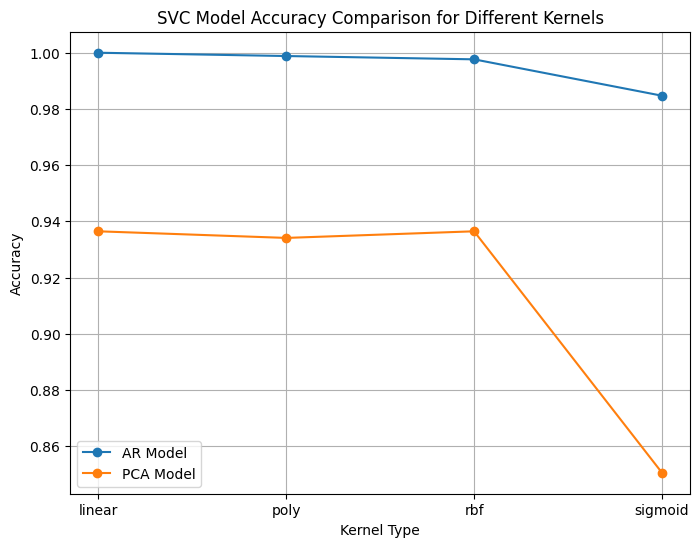

In [13]:
# SVC - Support Vector Classification

from sklearn.svm import SVC
import pandas as pd

# Define the SVC parameters
svc_params = {
    'C': 1.0,  # You can adjust other parameters here
}

# Kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Create a list to store the accuracies for AR and PCA
accuracies_ar = []
accuracies_pca = []

for kernel in kernels:
    # Create SVC models for AR data
    svc_ar = SVC(C=1.0, kernel=kernel)  # Specify the kernel here
    svc_ar.fit(X1_data,y)  # Use your training/validation data
    accuracy_ar = svc_ar.score(X1_data,y)  # Use your test data
    accuracies_ar.append(accuracy_ar)

    # Create SVC models for PCA data
    svc_pca = SVC(C=1.0, kernel=kernel)  # Specify the kernel here
    svc_pca.fit(X2_data,y)  # Use your training/validation data
    accuracy_pca = svc_pca.score(X2_data,y)  # Use your test data
    accuracies_pca.append(accuracy_pca)

# Create a DataFrame to display the results
metrics_table = pd.DataFrame({'Kernel': kernels, 'AR_Accuracy': accuracies_ar, 'PCA_Accuracy': accuracies_pca})
print(metrics_table)

# Plot the accuracies
plt.figure(figsize=(8, 6))
plt.plot(metrics_table['Kernel'], metrics_table['AR_Accuracy'], marker='o', label='AR Model')
plt.plot(metrics_table['Kernel'], metrics_table['PCA_Accuracy'], marker='o', label='PCA Model')
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy')
plt.title('SVC Model Accuracy Comparison for Different Kernels')
plt.legend()
plt.grid(True)
plt.show()

    k_values  AR_Accuracy  PCA_Accuracy
0          1     1.000000      1.000000
1          2     0.998824      0.948235
2          3     0.997647      0.950588
3          4     0.995294      0.944706
4          5     0.994118      0.937647
5          6     0.990588      0.940000
6          7     0.990588      0.937647
7          8     0.991765      0.940000
8          9     0.988235      0.937647
9         10     0.989412      0.937647
10        11     0.988235      0.936471
11        12     0.989412      0.938824
12        13     0.987059      0.929412
13        14     0.988235      0.935294
14        15     0.987059      0.929412
15        16     0.987059      0.932941
16        17     0.985882      0.924706
17        18     0.987059      0.924706
18        19     0.987059      0.924706


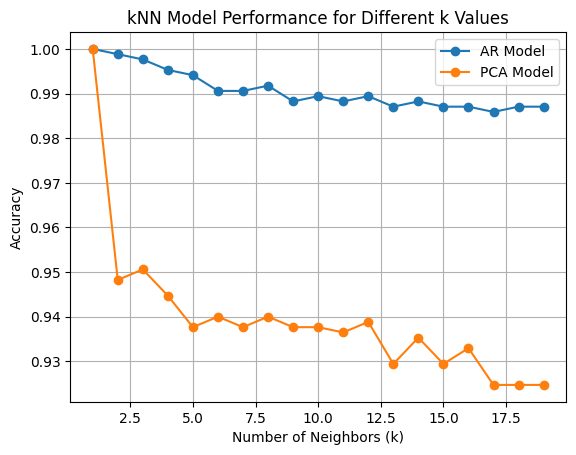

In [14]:
#k-Nearest Neighbors (kNN)

from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 20)  # A range of k values to test

accuracies_X1 = []  # To store accuracy values for each k
accuracies_X2 = []  # To store accuracy values for each k

for k in k_values:
    # Create and train the kNN model
    knn_X1 = KNeighborsClassifier(n_neighbors=k).fit(X1_data, y)
    knn_X2 = KNeighborsClassifier(n_neighbors=k).fit(X2_data, y)

    # Make predictions on the test data
    y_pred_X1 = knn_X1.predict(X1_data)
    y_pred_X2 = knn_X2.predict(X2_data)

    # Calculate accuracy and store it
    accuracy_X1 = accuracy_score(y, y_pred_X1)
    accuracies_X1.append(accuracy_X1)

    accuracy_X2 = accuracy_score(y, y_pred_X2)
    accuracies_X2.append(accuracy_X2)

# Create a DataFrame to display the results
metrics_table = pd.DataFrame({'k_values': k_values, 'AR_Accuracy': accuracies_X1, 'PCA_Accuracy': accuracies_X2})
print(metrics_table)

# Plot the results
plt.plot(k_values, accuracies_X1, marker='o',label='AR Model')
plt.plot(k_values, accuracies_X2, marker='o',label='PCA Model')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('kNN Model Performance for Different k Values')
plt.grid(True)
plt.legend()
plt.show()

**Análise**

Nos resultados apresentados por ambos os métodos, o desempenho dos modelos para os dados AR foi sempre superior. Apesar disto, os modelos funcionaram bem para classificar os dois conjuntos de dados.

Para os modelos SVM testados, a alteração do tipo de kernel não apresentou um impacto grande na precisão. Para o conjunto de dados AR, o modelo que mais se aproxima do linear é o Polynomial. Já para o conjunto de dados PCA, o linear e o RBF apresentam a mesma precisão.

Quanto ao modelos KNN, é possível observar que quanto maior o valor de k menor a precisão do modelo.



## HYPERPARAMETER TUNING (SOFTMAX, SVC, kNN)

**1. Split your dataset into a) training/validation and b) test datasets (e.g.
60/40% ratio split)**

**2. Use randomized search with repeated cross-validation for hyperparameter
tuning. Use e.g.**

**A. n_splits = 5, n_repeats = 50 [RepeatedKFold]**

**B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]**

**C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions,as shown in the slides [RandomizedSearchCV]**

**3. Try to compare with the results obtained with the default configurations of
each model constructor**

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV


#--- 1: Split the dataset: AR dataset (X1) and PCA dataset (X2)
X1_train_val, X1_test, y1_train_val, y1_test = train_test_split(X1_data, y, test_size=0.4, random_state=42)
X2_train_val, X2_test, y2_train_val, y2_test = train_test_split(X2_data, y, test_size=0.4, random_state=42)

# Define the models and their respective parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000),
        'param_grid': {'C': [0.1, 1.0, 10.0]}
    },
    'SVC': {
        'model': SVC(),
        'param_grid': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']}
    },
    'k-Nearest Neighbors (kNN)': {
        'model': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    }
}

# Lista para armazenar os resultados
results_X1 = []
results_X2 = []

# Loop through the models X1
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['param_grid']

    cv = RepeatedKFold(n_splits=5, n_repeats=50)
    rs = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=cv, scoring='accuracy')
    rs.fit(X1_train_val, y1_train_val)

    # # Print or store the results as needed
    # print(f"Model: {model_name}")
    # print(f"Best Parameters: {rs.best_params_}")
    # print(f"Best Score: {rs.best_score_}")
    # print("\n")

    # Armazenar resultados
    results_X1.append({
        'Modelo X1': type(model).__name__,
        'Melhores Hiperparâmetros X1': rs.best_params_,
        'Melhor Precisão X1': rs.best_score_
    })

# Criar DataFrame com os resultados
df_results_X1 = pd.DataFrame(results_X1)
# Exibir a tabela
print(df_results_X1)

# Loop through the models X2
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['param_grid']

    cv = RepeatedKFold(n_splits=5, n_repeats=50)
    rs = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=cv, scoring='accuracy')
    rs.fit(X2_train_val, y2_train_val)

    # # Print or store the results as needed
    # print(f"Model: {model_name}")
    # print(f"Best Parameters: {rs.best_params_}")
    # print(f"Best Score: {rs.best_score_}")
    # print("\n")

    # Armazenar resultados
    results_X2.append({
        'Modelo X2': type(model).__name__,
        'Melhores Hiperparâmetros X2': rs.best_params_,
        'Melhor Precisão X2': rs.best_score_
    })

# Criar DataFrame com os resultados
df_results_X2 = pd.DataFrame(results_X2)
# Exibir a tabela
print(df_results_X2)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              Modelo X1                Melhores Hiperparâmetros X1  \
0    LogisticRegression                                {'C': 10.0}   
1                   SVC             {'kernel': 'linear', 'C': 1.0}   
2  KNeighborsClassifier  {'weights': 'distance', 'n_neighbors': 3}   

   Melhor Precisão X1  
0            0.995804  
1            0.997686  
2            0.985608  


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              Modelo X2                Melhores Hiperparâmetros X2  \
0    LogisticRegression                                {'C': 10.0}   
1                   SVC              {'kernel': 'poly', 'C': 10.0}   
2  KNeighborsClassifier  {'weights': 'distance', 'n_neighbors': 5}   

   Melhor Precisão X2  
0            0.897412  
1            0.918510  
2            0.889373  
